ref: https://www.kaggle.com/code/sidharkal/brats2021

In [53]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import torch
import tarfile

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


In [9]:
zip_file = tarfile.open("BraTS2021_Training_Data.tar")
zip_file.extractall("./data")
zip_file.close()

In [11]:
Flair = nib.load('data/BraTS2021_00003/BraTS2021_00003_flair.nii.gz')
Seg = nib.load('data/BraTS2021_00003/BraTS2021_00003_seg.nii.gz')
T1 = nib.load('data/BraTS2021_00003/BraTS2021_00003_t1.nii.gz')
T1ce = nib.load('data/BraTS2021_00003/BraTS2021_00003_t1ce.nii.gz')
T2 = nib.load('data/BraTS2021_00003/BraTS2021_00003_t2.nii.gz')

In [20]:
Path = './data'
p = os.listdir(Path)

In [21]:
len(p)

1251

In [22]:
Input_Data= []

def Data_Preprocessing(modalities_dir):
    all_modalities = []    
    for modality in modalities_dir:      
        nifti_file   = nib.load(modality)
        brain_numpy  = np.asarray(nifti_file.dataobj)    
        all_modalities.append(brain_numpy)
    brain_affine   = nifti_file.affine
    all_modalities = np.array(all_modalities)
    all_modalities = np.rint(all_modalities).astype(np.int16)
    all_modalities = all_modalities[:, :, :, :]
    all_modalities = np.transpose(all_modalities)
    return all_modalities

for i in p[:10]:
    # print(i)
    brain_dir = os.path.normpath(Path+'/'+ i+'/' )
    flair     = glob.glob(os.path.join(brain_dir, '*_flair*.nii.gz'))
    t1        = glob.glob(os.path.join(brain_dir, '*_t1*.nii.gz'))
    t1ce      = glob.glob(os.path.join(brain_dir, '*_t1ce*.nii.gz'))
    t2        = glob.glob(os.path.join(brain_dir, '*_t2*.nii.gz'))
    gt        = glob.glob( os.path.join(brain_dir, '*_seg*.nii.gz'))
    modalities_dir = [flair[0], t1[0], t1ce[0], t2[0], gt[0]]
    P_Data = Data_Preprocessing(modalities_dir)
    Input_Data.append(P_Data)

BraTS2021_00000
BraTS2021_00002
BraTS2021_00003
BraTS2021_00005
BraTS2021_00006
BraTS2021_00008
BraTS2021_00009
BraTS2021_00011
BraTS2021_00012
BraTS2021_00014


In [25]:
Input_Data[0].shape

(155, 240, 240, 5)

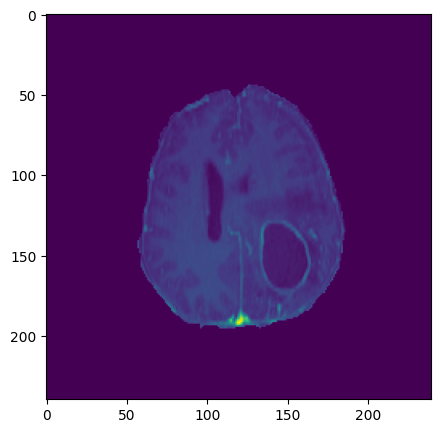

In [27]:
fig = plt.figure(figsize=(5,5))
immmg = Input_Data[3][100,:,:,2]
imgplot = plt.imshow(immmg)
plt.show()

In [43]:
# fundamentally it is just concatenating list along dim=0
def data_concatenate(input_data):
    counter = 0
    output = []
    for i in range(5):
        c = None
        counter = 0
        for ii in range(len(input_data)):
            if counter != len(input_data):
                a = torch.tensor(input_data[counter][:, :, :, i])
                b = torch.tensor(input_data[counter + 1][:, :, :, i])
                if counter == 0:
                    c = torch.cat((a, b), dim=0)
                    counter = counter + 2
                else:
                    c1 = torch.cat((a, b), dim=0)
                    c = torch.cat((c, c1), dim=0)
                    counter = counter + 2
        c = c.unsqueeze(3)
        output.append(c)
    return output

In [73]:
InData = data_concatenate(Input_Data)
AIO=torch.cat(InData,dim=3).numpy()
AIO=np.array(AIO,dtype='float32')
TR=np.array(AIO[:,:,:,1],dtype='float32') # it is taking in the first modelaity
TRL=np.array(AIO[:,:,:,4],dtype='float32') # it is taking in the last modelaity (sementation map or ground truth)

TRL[TRL==4]=3 # converting the 4th class to 3rd class

In [75]:
# Convert to PyTorch tensors
TR_tensor = torch.tensor(TR, dtype=torch.float32)
TRL_tensor = torch.tensor(TRL, dtype=torch.long)  # Assuming labels are integers


# Find indices where TRL has max value greater or equal to 1
valid_indices = torch.where(torch.max(TRL_tensor, dim=1).values >= 1)[0]

# Select valid data and labels using the found indices
TR_valid = TR_tensor[valid_indices]
TRL_valid = TRL_tensor[valid_indices]

TR_tensor=TR_valid.clone()
TRL_tensor=TRL_valid.clone()

in_dim=240
out_dim=240
num_classes=int(np.max(np.unique(TRL))+1)


# Split into training and validation sets
train_data, valid_data, train_labels, valid_labels = train_test_split(TR_tensor, TRL_tensor, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = TensorDataset(train_data, train_labels)
valid_dataset = TensorDataset(valid_data, valid_labels)

# Create data loaders
batch_size = 32  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data

In [86]:
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(UNet, self).__init__()
        
        self.conv_1 = self.conv_block(input_channels, 32)
        self.conv_2 = self.conv_block(32, 64)
        self.conv_3 = self.conv_block(64, 128)
        self.conv_4 = self.conv_block(128, 256)
        self.conv_5 = self.conv_block(256, 512)
        
        self.upsample_6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_6 = self.conv_block(512, 256)
        
        self.upsample_7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_7 = self.conv_block(256, 128)
        
        self.upsample_8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_8 = self.conv_block(128, 64)
        
        self.upsample_9 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv_9 = self.conv_block(64, 32)
        
        self.output_conv = nn.Conv2d(32, output_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        
        conv_1 = self.conv_1(x)
        maxp_1 = nn.MaxPool2d(kernel_size=2, stride=2)(conv_1)
        
        conv_2 = self.conv_2(maxp_1)
        maxp_2 = nn.MaxPool2d(kernel_size=2, stride=2)(conv_2)
        
        conv_3 = self.conv_3(maxp_2)
        maxp_3 = nn.MaxPool2d(kernel_size=2, stride=2)(conv_3)
        
        conv_4 = self.conv_4(maxp_3)
        maxp_4 = nn.MaxPool2d(kernel_size=2, stride=2)(conv_4)
        
        conv_5 = self.conv_5(maxp_4)
        upsample_6 = self.upsample_6(conv_5)
        
        concat_6 = torch.cat((upsample_6, conv_4), dim=1)
        conv_6 = self.conv_6(concat_6)
        upsample_7 = self.upsample_7(conv_6)
        
        concat_7 = torch.cat((upsample_7, conv_3), dim=1)
        conv_7 = self.conv_7(concat_7)
        upsample_8 = self.upsample_8(conv_7)
        
        concat_8 = torch.cat((upsample_8, conv_2), dim=1)
        conv_8 = self.conv_8(concat_8)
        upsample_9 = self.upsample_9(conv_8)
        
        concat_9 = torch.cat((upsample_9, conv_1), dim=1)
        conv_9 = self.conv_9(concat_9)
        
        outputs = self.output_conv(conv_9)
        return outputs.squeeze(1)  # Remove the added channel dimension


In [87]:
from sklearn.metrics import jaccard_score
import torch.optim as optim


def iou_score(y_true, y_pred):
    intersection = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()
    return intersection / union

def dice_coefficient(y_true, y_pred):
    intersection = (y_true & y_pred).sum()
    dice = (2.0 * intersection) / (y_true.sum() + y_pred.sum())
    return dice



unet_model=UNet(input_channels=1, output_channels=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet_model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)
total_epochs=10

for ep in range(total_epochs):
    running_loss = 0.0
    unet_model.train()
    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = unet_model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('Epoch: %d/%d | Loss: %.4f' %(ep+1,total_epochs, running_loss/len(train_loader)))


    # Validation
    unet_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    iou_sum = 0.0
    dice_sum = 0.0
    with torch.no_grad():
        for data, labels in valid_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = unet_model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            predicted_masks = outputs.argmax(dim=1)
            iou = iou_score(labels.bool(), predicted_masks.bool())
            dice = dice_coefficient(labels.bool(), predicted_masks.bool())
            iou_sum += iou
            dice_sum += dice
    
    avg_iou = iou_sum / len(valid_loader)
    avg_dice = dice_sum / len(valid_loader)
    print(f"Epoch {ep+1}/{total_epochs}, Validation Loss: {val_loss / len(valid_loader):.4f}, Avg IOU: {avg_iou:.4f}, Avg Dice: {avg_dice:.4f}")
    print('--------------------------------------------------------------')



Epoch: 1/10 | Loss: 0.2024
Epoch 1/10, Validation Loss: 0.1031, Avg IOU: 0.0000, Avg Dice: 0.0000
--------------------------------------------------------------
Epoch: 2/10 | Loss: 0.0555
Epoch 2/10, Validation Loss: 0.0323, Avg IOU: 0.8357, Avg Dice: 0.9104
--------------------------------------------------------------
Epoch: 3/10 | Loss: 0.0194
Epoch 3/10, Validation Loss: 0.0148, Avg IOU: 0.9177, Avg Dice: 0.9571
--------------------------------------------------------------
Epoch: 4/10 | Loss: 0.0123
Epoch 4/10, Validation Loss: 0.0107, Avg IOU: 0.9347, Avg Dice: 0.9662
--------------------------------------------------------------
Epoch: 5/10 | Loss: 0.0096
Epoch 5/10, Validation Loss: 0.0088, Avg IOU: 0.9474, Avg Dice: 0.9730
--------------------------------------------------------------
Epoch: 6/10 | Loss: 0.0083
Epoch 6/10, Validation Loss: 0.0071, Avg IOU: 0.9563, Avg Dice: 0.9776
--------------------------------------------------------------
Epoch: 7/10 | Loss: 0.0075
Epoch 7

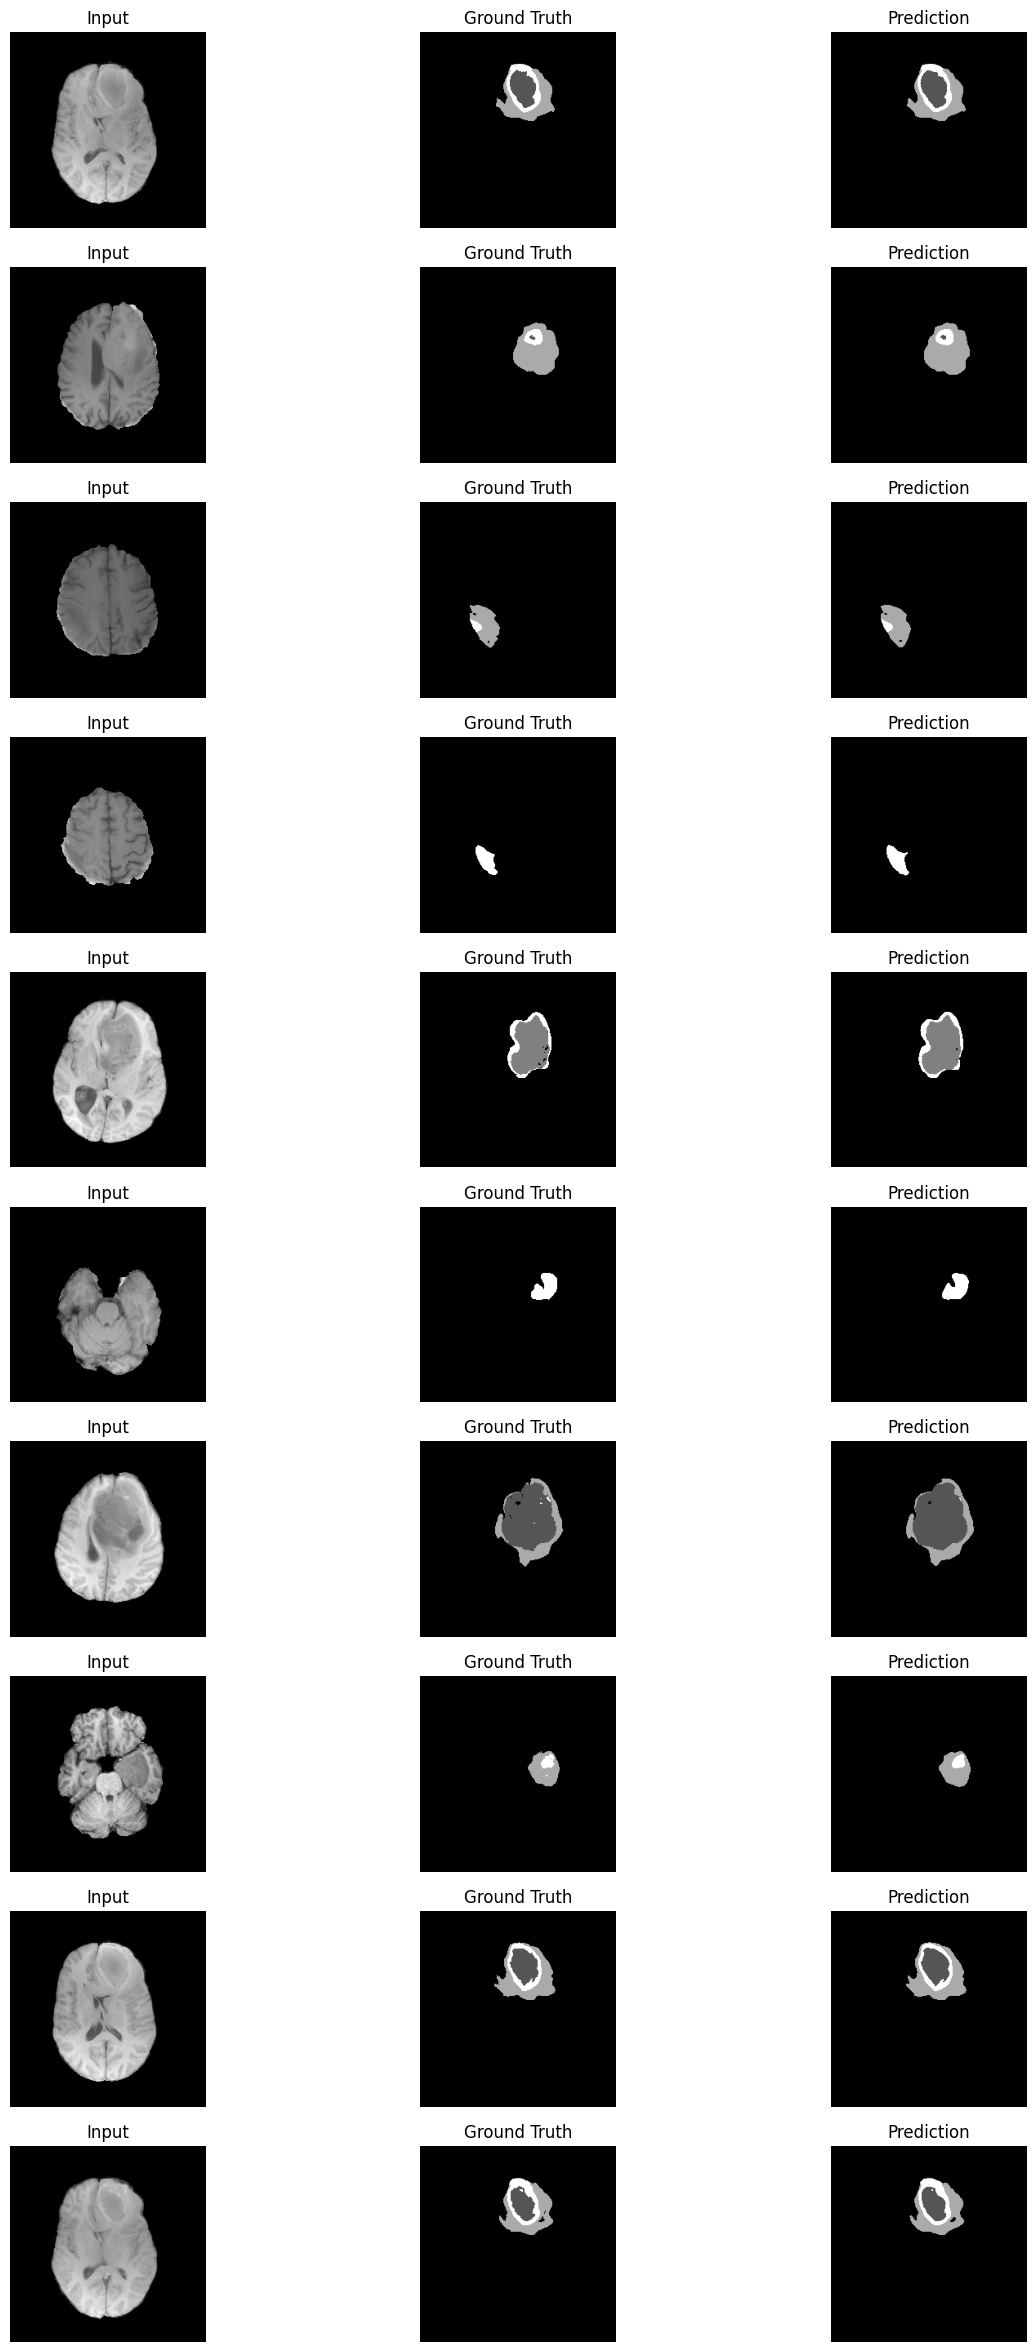

In [96]:
raw_data=next(iter(valid_loader))
idx=[0,1,2,3,4,5,6,7,8,9]
data=raw_data[0][idx]
labels=raw_data[1][idx]
preds=unet_model(data.to(device)).argmax(dim=1)


fig, ax = plt.subplots(10, 3, figsize=(15, 30))
for i in range(10):
    ax[i, 0].imshow(data[i].squeeze().cpu(), cmap='gray')
    ax[i, 1].imshow(labels[i].squeeze().cpu(), cmap='gray')
    ax[i, 2].imshow(preds[i].squeeze().cpu(), cmap='gray')
    ax[i, 0].set_title('Input')
    ax[i, 1].set_title('Ground Truth')
    ax[i, 2].set_title('Prediction')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')